## 1. Importing libraries

In [1]:
import torch
import gym
import numpy as np
import cv2
import time
import math
from matplotlib import pyplot as plt
from collections import deque

c:\Users\mario\anaconda3\envs\AI701Project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Checking availability of GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn)
    print('Device name:', torch.cuda.get_device_name(0))

Device:  cuda
__CUDNN VERSION: <module 'torch.backends.cudnn' from 'c:\\Users\\mario\\anaconda3\\envs\\AI701Project\\lib\\site-packages\\torch\\backends\\cudnn\\__init__.py'>
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


## 3. Creating the environment

In [3]:
env_si = gym.make("ALE/SpaceInvaders-v5")
env_si.seed(0);

env_c = gym.make("ALE/Carnival-v5")
env_c.seed(0);

env_ar = gym.make("ALE/AirRaid-v5")
env_ar.seed(0);

## 4. Performance of a random policy

In [4]:
def random_play(env):
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
        time.sleep(0.001)
    env.close()

In [24]:
random_play(env_si)

c:\Users\mario\anaconda3\envs\AI701Project\lib\site-packages\gym\envs\atari\environment.py:267: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(


Your Score at end of game is:  65.0


In [5]:
random_play(env_c)

c:\Users\mario\anaconda3\envs\AI701Project\lib\site-packages\gym\envs\atari\environment.py:267: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\mario\AppData\Roaming\Python\Python38\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Your Score at end of game is:  1340.0


In [6]:
random_play(env_ar)

Your Score at end of game is:  1475.0


## 5. Exploring the environments

In [17]:
for env in [env_si, env_c, env_ar]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(ALE/SpaceInvaders-v5) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/Carnival-v5) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/AirRaid-v5) frame is:  (250, 160, 3)
No. of Actions:  6


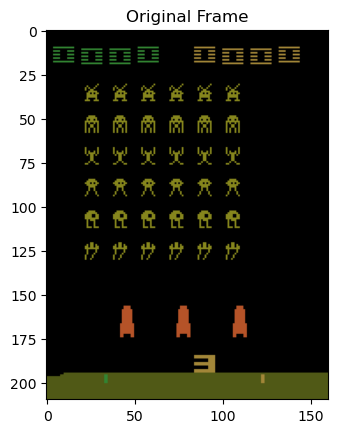

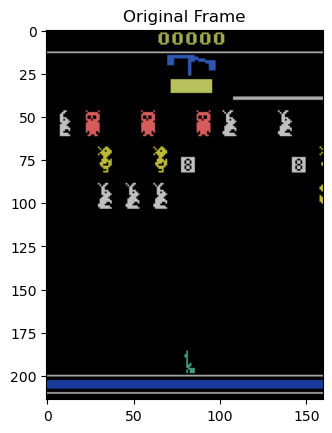

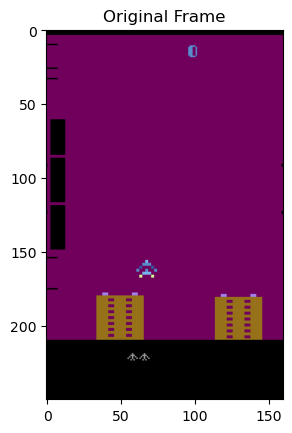

In [28]:
for env in [env_si, env_c, env_ar]:
    env.reset()
    plt.figure()
    plt.imshow(env.reset())
    plt.title('Original Frame')
    plt.show()

## 6. Image preprocessing and stacking frames

#### 6.1 Functions

In [ ]:
################ Image Preprocessing  ###################

def preprocess_observations(input_observation, prev_processed_observation, input_dimensions):
    # convert the 210x160x3 uint8 frame into a 6400 float vector 
    processed_observation = input_observation[35:195] # crop
    processed_observation = downsample(processed_observation)
    processed_observation = remove_color(processed_observation)
    processed_observation = remove_background(processed_observation)
    processed_observation[processed_observation != 0] = 1 # everything else (paddles, ball) just set to 1
    # Convert from 80 x 80 matrix to 1600 x 1 matrix
    processed_observation = processed_observation.astype(np.float).ravel()

    # subtract the previous frame from the current one so we are only processing on changes in the game
    if prev_processed_observation is not None:
        input_observation = processed_observation - prev_processed_observation
    else:
        input_observation = np.zeros(input_dimensions)
    # store the previous frame so we can subtract from it next time
    prev_processed_observations = processed_observation
    return input_observation, prev_processed_observations


def remove_background(image):
    image[image == 144] = 0
    image[image == 109] = 0
    return image

def downsample(image):
    # We will take only half of the image resolution
    return image[::2, ::2, :]

def remove_color(image):
    # We dont need the image colors
    return image[:, :, 0]

#### 6.2 Image preview

## 7. Neural networks

## 8. Hyperparameters

In [30]:
input_shape = ???
action_size = env_si.action_space.n
seed = 0
gamma = 0.99           # discount factor
buffer_size = 100000   # replay buffer size
batch_size = 64        # Update batch size
learning_rate = 0.0001            # learning rate 
tau = 1e-3             # for soft update of target parameters
update_every = 1       # how often to update the network
update_after = 10000  # After which thershold replay to be started

# Exploration vs Explotaition tradeoff, epsilon decays over time
eps_start = 0.99        # starting value of epsilon
eps_end = 0.01          # Ending value of epsilon
eps_decay = 100         # Rate by which epsilon to be decayed

## 9. Watching it play before training

## 10. Training the agent

#### 10.1 Decay of epsilon

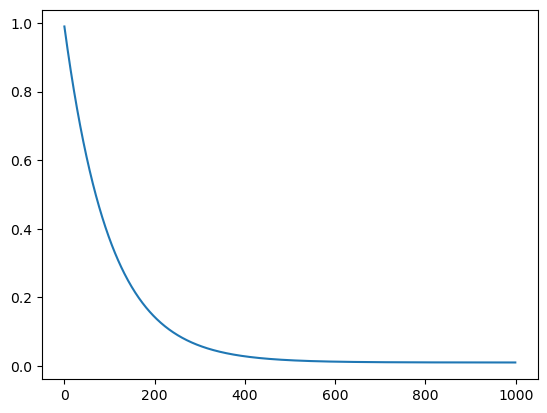

In [33]:
epsilon_by_episode = lambda frame_idx: eps_end + (eps_start - eps_end) * math.exp(-1. * frame_idx /eps_decay)
plt.plot([epsilon_by_episode(i) for i in range(1000)])

#### 10.2 Main training algorithm

In [ ]:
(st,at,rt,st+1)
frame1,frame2,frame3,frame4, frame2,frame3,frame4,frame5

In [ ]:
4 stacked, convolutional layers... fully connected -> [a0, a1, a2, a3]

![alt text](dql_algorithm.jpg "Title")

In [ ]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    start_epoch = 0
    scores = []
    scores_window = deque(maxlen=20)

    ########### Initialize replay memory D to capacity N (most of the sources indicate that N should be 1 million)
    ########### Initialize action-value function Q with random weights Theta
    ########### Initialize target action-value function Q_hat with weights Theta_ = Theta

    for i_episode in range(start_epoch + 1, n_episodes+1):
        #state = stack_frames(None, env.reset(), True) ############ Here we need the preprocessing function
        score = 0
        eps = epsilon_by_episode(i_episode)
        C = 0
        while True:
            #action = agent.act(state, eps)  ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy

            next_state, reward, done, info = env.step(action)
            
            #next_state = stack_frames(state, next_state, False) ############ Here we need the preprocessing function
            
            ############### Here we store the transition (phi_(t), a_(t), r_(t), phi_(t+1)) in D

            ################# Training phase ######################
            ####### 1.- Sample random minibatch with uniform distribution of transitions (phi_(j), a_(j), r_(j), phi_(j+1)) from D
            ####### 2.- Calculate the target value "y"
            ####### 3.- Perform a gradient descent step on ACTION-VALUE function, not target action-value function
            #######################################################
            
            #state = next_state
            score += reward

            ############### Every C steps reset Q_hat = Q, we train only on Q
            if C % 20 == 0:
                Q_hat = copy.deepcopy(Q)
                ####### Or
                Q_hat.load_state_dict(Q.state_dict())
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Plotting
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return scores

## 11. Evaluate the agent

In [ ]:
score = 0
#state = stack_frames(None, env.reset(), True) ############ Here we need the preprocessing function
while True:
    env.render()
    #action = agent.act(state, eps)  ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy
    next_state, reward, done, _ = env.step(action)
    score += reward
    #state = stack_frames(state, next_state, False) ########## Here we need the preprocessing function
    if done:
        print("You Final score is:", score)
        break 
env.close()